In [6]:
#Run on geo_env
#This is an approximate version of the code that DOES NOT uncorrelate the wind/wave time observations.
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import sys
from scipy.stats import weibull_min
from scipy.stats import lognorm
from scipy.stats import norm
from tqdm import tqdm
from scipy.spatial import ConvexHull
import h5py
import pandas as pd
from functools import partial

from scipy.optimize import curve_fit
from multiprocessing import Pool

sys.path.append('./Tools')
from Port_Opt_Tools import GetOverlaps_Idx_Area
from GeneralGeoTools import PlotGeneralGeoData_Class, PlotGeneralGeoData

sys.path.append('./Tools/Multiprocessing')
from EVA_WaveWind import ComputeExtremeSurface_Multiprocessing

PathWindData="./InputData/Wind/windspeed_140m.npz"
PathWaveDate="./InputData/Wave/WWIII_2005_2019.npz"
GeoDataPath="./InputData/CoastLine/"

# Preprocess Data

In [19]:
#Wave Data
Npz_Wave=np.load(PathWaveDate, allow_pickle=True)
WaveLatLong=Npz_Wave["LatLong"]
WaveHs=Npz_Wave["Hs"]
WaveTp=Npz_Wave["Tp"]
WaveDepth=Npz_Wave["Depth"]
WaveDistanceShore=Npz_Wave["DistanceShore"]
WaveDTime=list(Npz_Wave["DateTimeList"])

#Winda Data
Npz_Wind=np.load(PathWindData, allow_pickle=True)
WindSpeed=Npz_Wind["windspeed"]
WindLatLong=Npz_Wind["LatLong"]
WindDTime=[ datetime(2007, 1, 1, 0, 0, 0)+timedelta(hours=i) for i in range(WindSpeed.shape[0])] # Start at 2007-01-01 00:00:00, step 1 hour

#Constraint wave data to the same range as wind data (2007/01/01 - 2013/12/31-21)
#Remove the last 2h from wind data to match the wave data
WindSpeed=WindSpeed[:-2,:]
WindDTime=WindDTime[:-2]

WaveHs=WaveHs[:, WaveDTime.index(WindDTime[0]):WaveDTime.index(WindDTime[-1])+1]
WaveTp=WaveTp[:, WaveDTime.index(WindDTime[0]):WaveDTime.index(WindDTime[-1])+1]

WaveDTime=WaveDTime[WaveDTime.index(WindDTime[0]):WaveDTime.index(WindDTime[-1])+1]

#Thake the average for the wind data each 3h
WindSpeed=np.array([np.mean(WindSpeed[i:i+3,:], axis=0) for i in range(0, WindSpeed.shape[0], 3)]).T

#Here we need to compute an average wind speed based on the wave data site radius
IdxOverlap, _, _, _, _=GetOverlaps_Idx_Area=GetOverlaps_Idx_Area(WaveLatLong, [-1]*len(WaveLatLong), [1/15]*len(WaveLatLong), [0]*len(WindLatLong),
                         WindLatLong, [2]*len(WindLatLong), [-1]*len(WindLatLong), [0]*len(WindLatLong), SameTech=0)


Hs=WaveHs[np.unique(IdxOverlap[:,0]),:]
Tp=WaveTp[np.unique(IdxOverlap[:,0]),:]
WaveDepth=WaveDepth[np.unique(IdxOverlap[:,0])]
WaveDistanceShore=WaveDistanceShore[np.unique(IdxOverlap[:,0])]
WaveLatLong=WaveLatLong[np.unique(IdxOverlap[:,0]),:]

WS_new=np.ones((len(np.unique(IdxOverlap[:,0])), WindSpeed.shape[1]))*-1

for i, i_wave in enumerate(np.unique(IdxOverlap[:,0])):
    IdxOverlap_i=np.where(IdxOverlap[:,0]==i_wave)[0]
    WS_new[i,:]=np.mean(WindSpeed[IdxOverlap[IdxOverlap_i,1],:], axis=0) #Wind speed at the wave site

LatLong=WaveLatLong
# Verify the statistics of WS_new and Hs and Tp

100%|██████████| 732/732 [00:07<00:00, 99.53it/s] 


In [24]:
AvgWind=np.mean(WS_new, axis=1)
EnergyFlux=0.5*(WaveHs**2)*WaveTp
EnergyFlux=EnergyFlux.mean(axis=1)

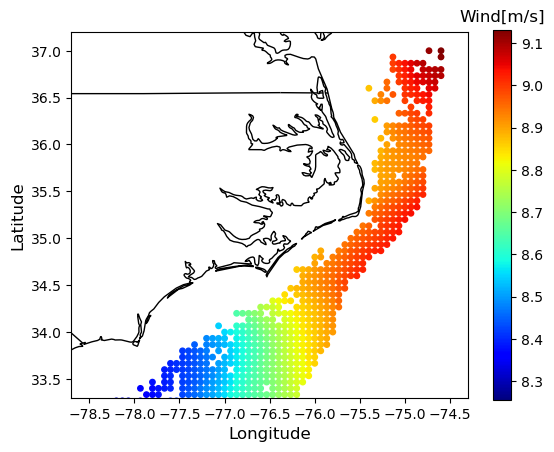

In [26]:
PlotGeneralGeoData(LatLong, AvgWind, GeoDataPath, ColorBarTitle="Wind[m/s]", Title=None, SavePath=None, s=15, LatMaxMin=(33.3, 37.2), LongMaxMin=(-78.7, -74.3))

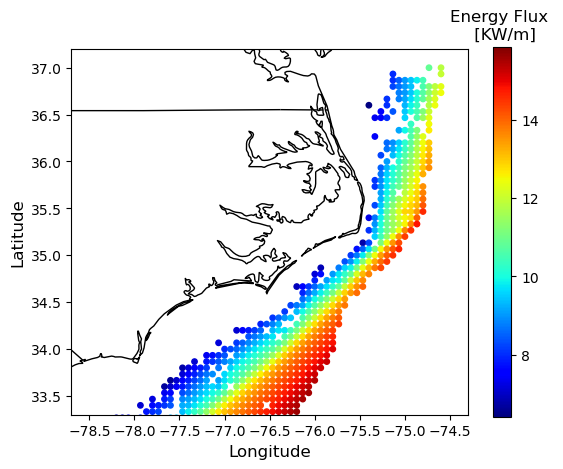

In [27]:
PlotGeneralGeoData(LatLong, EnergyFlux, GeoDataPath, ColorBarTitle='Energy Flux \n [KW/m]', Title=None, SavePath=None, s=15, LatMaxMin=(33.3, 37.2), LongMaxMin=(-78.7, -74.3))

# Verify the statistics of WS_new, Hs and Tp

## f(WS)~ Two parameter Weibull

In [3]:
ParamWS_Weibull=[]
def FitWeibull_WS(WS_i, PlotFig=False):
    def weibull_pdf(x, shape, loc, scale):
        return weibull_min.pdf(x, shape, loc=loc, scale=scale)

    # Create bins and histogram
    bins = np.linspace(min(WS_i), max(WS_i), 50)
    hist, bin_edges = np.histogram(WS_i, bins=bins, density=True)

    # Get the x values (midpoints of bins)
    x_values = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Fit the Weibull distribution to the data using curve_fit
    params, covariance = curve_fit(weibull_pdf, x_values, hist)


    # Extract the fitted parameters
    shape_ws, loc_ws, scale_ws = params

    # Create a range of values for plotting
    x_values = np.linspace(min(WS_i), max(WS_i), 1000)

    if PlotFig==True:
        # Plot the histogram of the data
        plt.hist(WS_i, bins=50, density=True, alpha=0.7, label='Histogram')

        # Plot the fitted Weibull distribution
        plt.plot(x_values, weibull_pdf(x_values, shape_ws, loc_ws, scale_ws ), 'r-', label='Fitted Weibull')

        plt.legend()
        plt.title('Fitting Weibull Distribution to Wind Speed')
        plt.xlabel('Wind Speed (m/s)')  
        plt.ylabel('Probability Density')
        plt.show()

    return shape_ws, loc_ws, scale_ws

for i in range(WS_new.shape[0]):
    WS_i=WS_new[i,:]
    ParamWS_Weibull.append(FitWeibull_WS(WS_i))

In [28]:
LatLong[414,:]

array([ 33.866601  , -76.93333333])

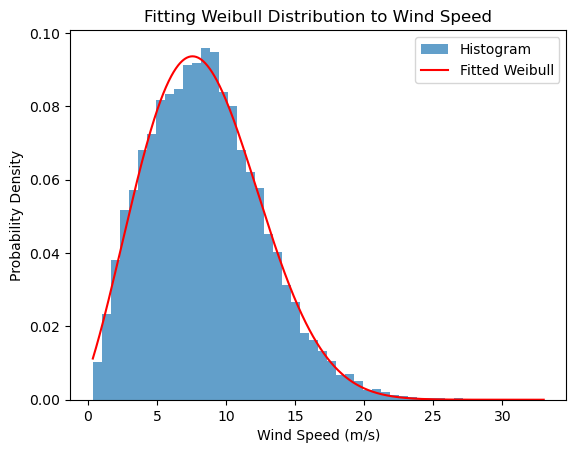

(2.4376975708682926, -0.9401622945741372, 10.567447548503013)

In [4]:
SiteIdx=414
WS_i=WS_new[SiteIdx,:]

FitWeibull_WS(WS_i,PlotFig=True)

## f(Hs|Uw) ~ Two parameter Weibull

In [5]:
#Sample at each 1m/s wind speed

def FitWeibull_HsUw(SiteIdx, Hs=Hs, Tp=Tp,WS_new=WS_new,  PlotFig=False):
    Uw_RefRange=[]
    Uw_RefRange.append(0)

    WS_i=WS_new[SiteIdx,:]
    Hs_i=Hs[SiteIdx,:]
    Params=[]
    #Validade Bin Range, it must have at least 1% of the data
    UwRange=0.1
    UwRange2=2
    
    for i in range(int(30/0.1)):
        
        Uw_r=(1+i)*UwRange
        R_data=np.sum((WS_new[SiteIdx,:]>=Uw_r-UwRange2 ) * (Hs[SiteIdx,:]<Uw_r+UwRange2))/len(WS_new[SiteIdx,:])
        if R_data>0.05:
            Uw_RefRange.append(Uw_r)
            
            
    Uw_RefRange=Uw_RefRange[:-1]
    Uw_RefRange.append(30) #jsut make sure that the last bin is big enough



    # Define the probability density function (PDF) of the log-normal distribution
    # def lognorm_pdf(x, s, loc, scale):
    #     return lognorm.pdf(x, s, loc=loc, scale=scale)

    def weibull_pdf(x, shape, loc, scale):
        return weibull_min.pdf(x, shape, loc=loc, scale=scale)

    c=0
    for i in range(len(Uw_RefRange[:-1])):
        IdxIn=(WS_new[SiteIdx,:]>=Uw_RefRange[i]-UwRange2)* (WS_new[SiteIdx,:]<Uw_RefRange[i+1]+UwRange2)
        Hs_i=Hs[SiteIdx,:]
        Hs_i=Hs_i[IdxIn]
        
        WS_new_i=WS_new[SiteIdx,:]
        Ws_i=WS_new_i[IdxIn]
        

        # Create bins and histogram
        bins = np.linspace(min(Hs_i), max(Hs_i), 50)
        hist, bin_edges = np.histogram(Hs_i, bins=bins, density=True)

        # Get the x values (midpoints of bins)
        x_values = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Fit the log-normal distribution to the data using curve_fit
        params, covariance = curve_fit(weibull_pdf, x_values, hist,maxfev=2000,bounds=([2,0,0], [np.inf, np.inf, np.inf]))

        # Extract the fitted parameters
        s, loc, scale = params
        Params.append([s, loc, scale])
        css4_colors = plt.get_cmap('tab20').colors 
        if PlotFig==True and i%20==0 and i>0:
            
            # Create a range of values for plotting
            x_values_plot = np.linspace(min(Hs_i), max(Hs_i), 1000)

            # Plot the histogram of the data
            plt.hist(Hs_i, bins=bins, density=True, alpha=0.7,color=css4_colors[c])

            # Plot the fitted log-normal distribution
            plt.plot(x_values_plot, weibull_pdf(x_values_plot, s, loc, scale),c=css4_colors[c], label="Ws: "+"{:.1f}".format(np.max([(Uw_RefRange[i]-UwRange2),0]))+"-"+"{:.1f}".format((Uw_RefRange[i]+UwRange2)))
            c+=1

    if PlotFig==True:
        #Legend in the left , no framere
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,frameon=False)
        plt.title('Fitting Weibull Distribution to Hs|Ws')
        plt.xlabel('Hs (m)')
        plt.ylabel('Probability Density')
        plt.show()   
    
    return Params, Uw_RefRange

ParamHs_Ws=[]
HsUw_RefRange=[]
for i in tqdm(range(Hs.shape[0])):
    Params, Uw_RefRange=FitWeibull_HsUw(i, PlotFig=False)
    ParamHs_Ws.append(Params)
    HsUw_RefRange.append(Uw_RefRange)
    

100%|██████████| 732/732 [18:10<00:00,  1.49s/it]


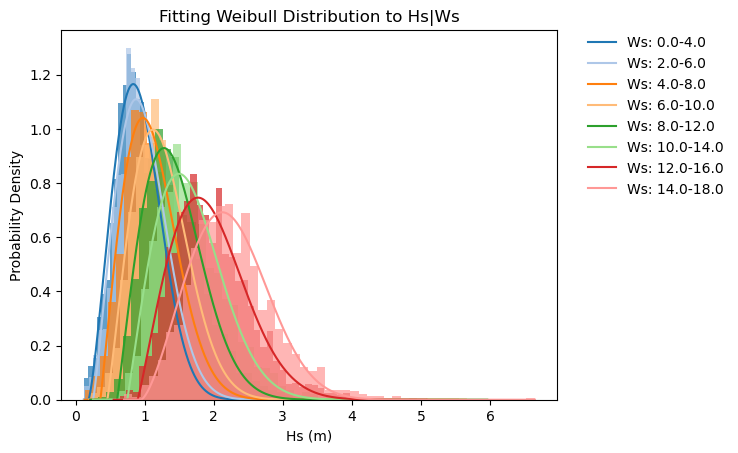

In [6]:
Params, Hs_RefRange=FitWeibull_HsUw(414, PlotFig=True)

## F(Tp|Hs) ~ LogNormal Distribution/ or two parameter Weibull

In [31]:
def FitWeibull_TpHs(SiteIdx, Hs=Hs, Tp=Tp,  PlotFig=False):
    Hs_RefRange=[]
    Hs_RefRange.append(0)

    Hs_i=Hs[SiteIdx,:]
    Tp_i=Tp[SiteIdx,:]
    Params=[]
    #Validade Bin Range, it must have at least 1% of the data
    HsRange=0.1
    HsRange2=1
    
    for i in range(int(30/0.1)):
        
        Hs_r=(1+i)*HsRange
        R_data=np.sum((Hs[SiteIdx,:]>=Hs_r-HsRange2 ) * (Hs[SiteIdx,:]<Hs_r+HsRange2))/len(Hs[SiteIdx,:])
        if R_data>0.05:
            Hs_RefRange.append(Hs_r)
            
            
    Hs_RefRange=Hs_RefRange[:-1]
    Hs_RefRange.append(30) #jsut make sure that the last bin is big enough

    # Define the probability density function (PDF) of the log-normal distribution
    # def lognorm_pdf(x, s, loc, scale):
    #     return lognorm.pdf(x, s, loc=loc, scale=scale)

    def weibull_pdf(x, shape, loc, scale):
        return weibull_min.pdf(x, shape, loc=loc, scale=scale)
    c=0
    for i in range(len(Hs_RefRange[:-1])):
        IdxIn=(Hs[SiteIdx,:]>=Hs_RefRange[i]-HsRange2)* (Hs[SiteIdx,:]<Hs_RefRange[i+1]+HsRange2)
        Hs_i=Hs[SiteIdx,:]
        Hs_i=Hs_i[IdxIn]
        
        Tp_i=Tp[SiteIdx,:]
        Tp_i=Tp_i[IdxIn]
        

        # Create bins and histogram
        bins = np.linspace(min(Tp_i), max(Tp_i), 50)
        hist, bin_edges = np.histogram(Tp_i, bins=bins, density=True)

        # Get the x values (midpoints of bins)
        x_values = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Fit the log-normal distribution to the data using curve_fit
        params, covariance = curve_fit(weibull_pdf, x_values, hist,maxfev=2000 ,bounds=([0,0,0], [np.inf, np.inf, np.inf]))

        # Extract the fitted parameters
        s, loc, scale = params
        Params.append([s, loc, scale])
        css4_colors = plt.get_cmap('tab20').colors 
        
        if PlotFig==True and i%7==0 and i>0:
            # Create a range of values for plotting
            x_values_plot = np.linspace(min(Tp_i), max(Tp_i), 1000)

            # Plot the histogram of the data
            plt.hist(Tp_i, bins=bins, density=True, alpha=0.7,color=css4_colors[c])

            # Plot the fitted log-normal distribution
            plt.plot(x_values_plot, weibull_pdf(x_values_plot, s, loc, scale),c=css4_colors[c],label="Hs: "+"{:.1f}".format(np.max([(Hs_RefRange[i]-HsRange2),0]))+"-"+"{:.1f}".format((Hs_RefRange[i]+HsRange2)))
            c+=1

    if PlotFig==True:
        plt.legend(frameon=False)
        plt.title('Fitting Weibull Distribution to Tp|Hs')
        plt.xlabel('Tp (s)')
        plt.ylabel('Probability Density')
        plt.show()   
    
    return Params, Hs_RefRange

ParamTpHs=[]
Tp_Hs_RefRange=[]
for i in tqdm(range(Hs.shape[0])):
    Params, Hs_RefRange=FitWeibull_TpHs(i, PlotFig=False)
    ParamTpHs.append(Params)
    Tp_Hs_RefRange.append(Hs_RefRange)
    

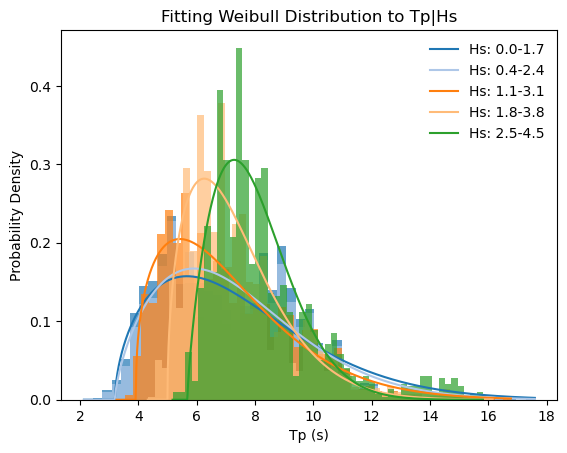

In [32]:
Params, Hs_RefRange=FitWeibull_TpHs(414, PlotFig=True)

In [9]:
Data={"ParamWS_Weibull":ParamWS_Weibull, "ParamHs_Ws":ParamHs_Ws, "HsUw_RefRange":HsUw_RefRange,
         "ParamTpHs":ParamTpHs, "Tp_Hs_RefRange":Tp_Hs_RefRange}

np.savez("./InputData/Wave/EVA_Params.npz", Data=Data)

# Compute Extreme events (All distributions must be Weibull)

In [30]:
Data=np.load("./InputData/Wave/EVA_Params.npz", allow_pickle=True)["Data"].item()
ParamWS_Weibull=Data["ParamWS_Weibull"]
ParamHs_Ws=Data["ParamHs_Ws"]
HsUw_RefRange=Data["HsUw_RefRange"]
ParamTpHs=Data["ParamTpHs"]
Tp_Hs_RefRange=Data["Tp_Hs_RefRange"]

In [4]:
# Here I am basing the theory on https://asmedigitalcollection.asme.org/offshoremechanics/article/137/3/031901/377037/Joint-Distribution-of-Environmental-Condition-at
#Rosenblatt transformation

#Definition on P(Ws)
Param_Ws=ParamWS_Weibull

#Definition on P(Hs|Ws)
Param_Hs_Ws=ParamHs_Ws
Bins_Hs_Ws=HsUw_RefRange

#Definition on P(Tp|Hs)
Param_Tp_Hs=ParamTpHs
Bins_Tp_Hs=Tp_Hs_RefRange

#range of values we will numerically investigate
Ws_EVA_Range=np.arange(0,40,0.2)
Hp_EVA_Range=np.arange(0,30,0.2)
Tp_EVA_Range=np.arange(0,40,0.5)

NSites=len(Param_Hs_Ws)

def weibull_CDF(x, shape, loc, scale):
    return weibull_min.cdf(x, shape, loc=loc, scale=scale)



def ComputeExtremeSurface(s, Recurrency=50):
    #Definition on P(Ws)
    Param_Ws_s=Param_Ws[s]

    #Definition on P(Hs|Ws)
    Param_Hs_Ws_s=ParamHs_Ws[s]
    Bins_Hs_Ws_s=np.array(Bins_Hs_Ws[s])

    #Definition on P(Tp|Hs)
    Param_Tp_Hs_s=Param_Tp_Hs[s]
    Bins_Tp_Hs_s=np.array(Bins_Tp_Hs[s])

    ProbSurfaceVariables=[]
    ProbSurfaceValue=[]
    MaxRadius=norm.ppf(1-1/(365*24/3*Recurrency))
    MaxRadius2=MaxRadius**2
    for Ws_r in Ws_EVA_Range:
        
        #Wind
        y1=norm.ppf(weibull_CDF(Ws_r, Param_Ws_s[0], Param_Ws_s[1], Param_Ws_s[2]))
        if y1**2<=MaxRadius2:
            for Hp_r in Hp_EVA_Range:
                
                #Wave height
                #get index of the bin
                Idx_Hs_Ws_closest=np.max([np.argmax(Bins_Hs_Ws_s>=Ws_r)-1,0])
                Param_Hs_Ws_s_i=Param_Hs_Ws_s[Idx_Hs_Ws_closest]

                y2=norm.ppf(weibull_CDF(Hp_r, Param_Hs_Ws_s_i[0], Param_Hs_Ws_s_i[1], Param_Hs_Ws_s_i[2]))

                if y1**2+y2**2<=MaxRadius2:
                    for Tp_r in Tp_EVA_Range:
                        #Wave period
                        #get index of the bin
                        Idx_Tp_Hs_closest=np.max([np.argmax(Bins_Tp_Hs_s>=Hp_r)-1,0])
                        Param_Tp_Hs_s_i=Param_Tp_Hs_s[Idx_Tp_Hs_closest]

                        y3=norm.ppf(weibull_CDF(Tp_r, Param_Tp_Hs_s_i[0], Param_Tp_Hs_s_i[1], Param_Tp_Hs_s_i[2]))

                        r2=y1**2+y2**2+y3**2
                        if r2<=MaxRadius2:
                            ProbSurfaceVariables.append([Ws_r, Hp_r, Tp_r])
    
    return ProbSurfaceVariables

ProbSurfaceVariables=ComputeExtremeSurface(1)

# for s in tqdm(range(NSites)):
#     ComputeExtremeSurface(s)

In [5]:
IdxIn=list(range(NSites))

if __name__ == '__main__':
   with Pool(15) as p:
      Results = list(tqdm(p.imap(ComputeExtremeSurface_Multiprocessing, IdxIn), total=len(IdxIn)))

Data={"Results":Results}
np.savez("./InputData/Wave/EVA_50y_ProbSurfaceVariables.npz", Data=Data)

100%|██████████| 732/732 [36:29<00:00,  2.99s/it]  


In [7]:
IdxIn=list(range(NSites))
partial_func = partial(ComputeExtremeSurface_Multiprocessing, Recurrency=100)
if __name__ == '__main__':
   with Pool(16) as p:
      Results = list(tqdm(p.imap(partial_func, IdxIn), total=len(IdxIn)))

Data={"Results":Results}
np.savez("./InputData/Wave/EVA_100y_ProbSurfaceVariables.npz", Data=Data)

100%|██████████| 732/732 [38:11<00:00,  3.13s/it]  


# EVA Plots: Investigation

## 50 Yrs

In [8]:
Data=np.load("./InputData/Wave/EVA_50y_ProbSurfaceVariables.npz", allow_pickle=True)["Data"].item()
Results=Data["Results"]


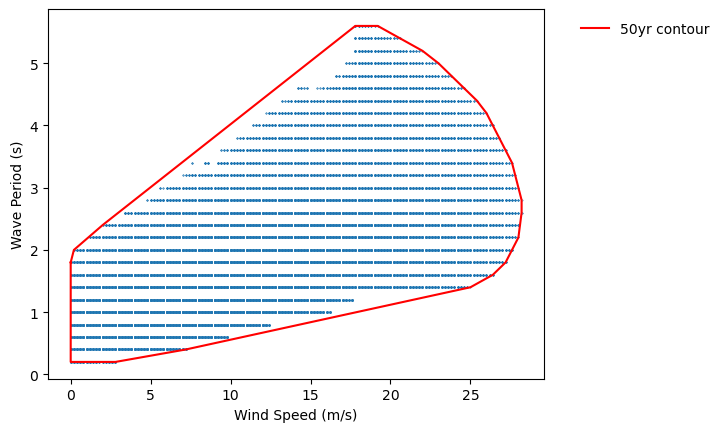

In [54]:
ProbSurfaceVariables=Results[414]
def PlotSingleCurve(ProbSurfaceVariables):
    x=np.array(ProbSurfaceVariables)[:,0]
    y=np.array(ProbSurfaceVariables)[:,1]
    #get the outer boundary
    # Combine x and y points into a single array
    points = np.column_stack((x, y))

    # Compute the convex hull
    hull = ConvexHull(points)

    # Extract the outer boundary points
    outer_boundary_points = np.append(points[hull.vertices], [points[hull.vertices][0]], axis=0)

    plt.plot(outer_boundary_points[:, 0], outer_boundary_points[:, 1], 'r-', label='50yr contour')
            

    plt.scatter(x, y,s=0.1)

    plt.xlabel("Wind Speed (m/s)")
    plt.ylabel("Wave Height (m)")
    plt.ylabel("Wave Period (s)")
    #legend on the left, outside the plot
    plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc='upper left')

PlotSingleCurve(ProbSurfaceVariables)

100%|██████████| 732/732 [00:24<00:00, 29.59it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


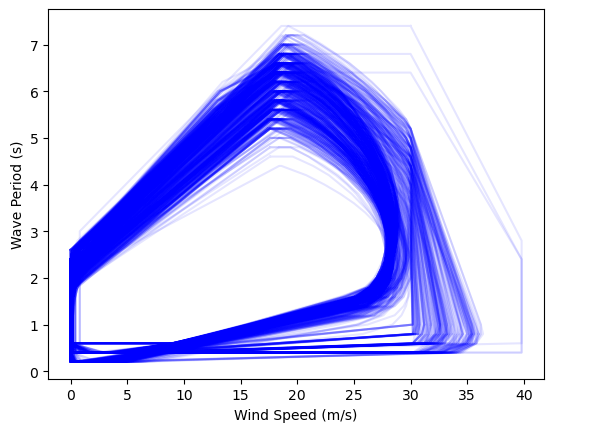

In [13]:
for i in tqdm(range(len(Results))):
    ProbSurfaceVariables=Results[i]
    x=np.array(ProbSurfaceVariables)[:,0]
    y=np.array(ProbSurfaceVariables)[:,1]
    #get the outer boundary
    # Combine x and y points into a single array
    points = np.column_stack((x, y))

    # Compute the convex hull
    hull = ConvexHull(points)

    # Extract the outer boundary points
    outer_boundary_points = np.append(points[hull.vertices], [points[hull.vertices][0]], axis=0)

    plt.plot(outer_boundary_points[:, 0], outer_boundary_points[:, 1], 'b-', alpha=0.1)


#Overlap of all sites

plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Wave Height (m)")

#legend on the left, outside the plot
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc='upper left')


100%|██████████| 732/732 [00:24<00:00, 29.96it/s]


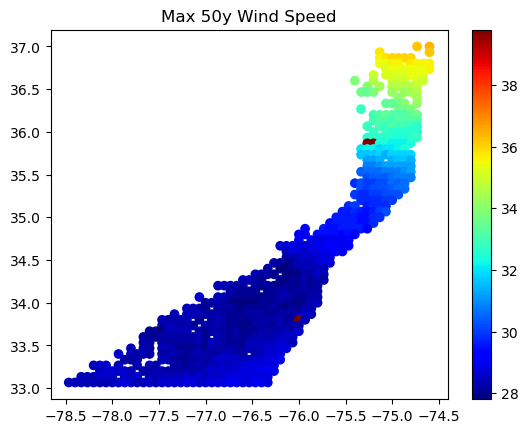

In [55]:
#Wave Data
Npz_Wave=np.load(PathWaveDate, allow_pickle=True)
LatLong=Npz_Wave["LatLong"]

Max50yWind=[]
Max50yWaveHeight=[]
for i in tqdm(range(len(Results))):
    ProbSurfaceVariables=Results[i]
    x=np.array(ProbSurfaceVariables)[:,0]
    y=np.array(ProbSurfaceVariables)[:,1]
    Max50yWind.append(np.max(x))
    Max50yWaveHeight.append(np.max(y))

plt.scatter(LatLong[:,1], LatLong[:,0], c=Max50yWind, cmap='jet')
plt.colorbar()
plt.title("Max 50y Wind Speed")

#The indexed above 37 m/s of wind speed does not look consitent, lets exclude them
Max50yWind=np.array(Max50yWind)
Max50yWaveHeight=np.array(Max50yWaveHeight)
Idx=np.where(Max50yWind<37)[0]

In [20]:
Max50yWind=[]
Max50yWaveHeight=[]
for i in tqdm(Idx):
    ProbSurfaceVariables=Results[i]
    x=np.array(ProbSurfaceVariables)[:,0]
    y=np.array(ProbSurfaceVariables)[:,1]
    Max50yWind.append(np.max(x))
    Max50yWaveHeight.append(np.max(y))


100%|██████████| 729/729 [00:23<00:00, 30.99it/s]


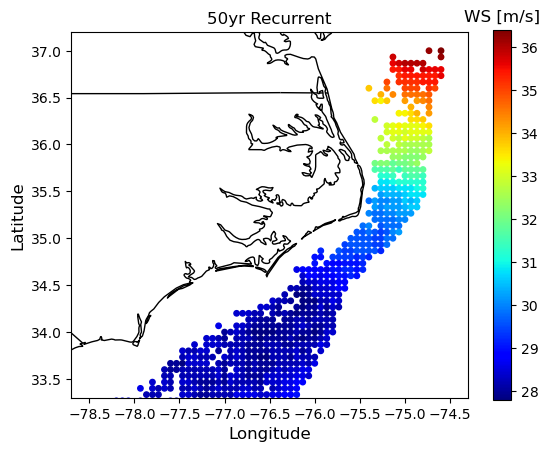

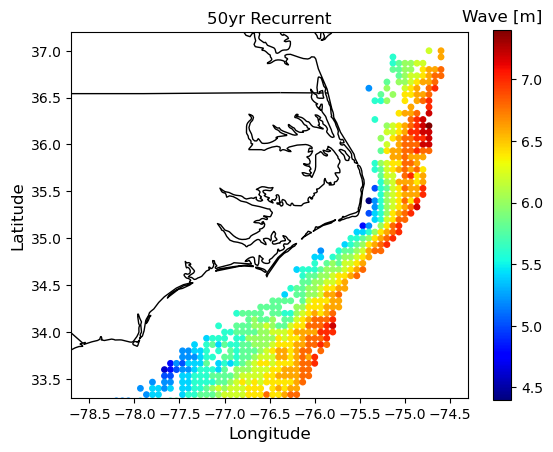

In [35]:
PlotGeneralGeoData(LatLong[Idx,:], Max50yWind, GeoDataPath, ColorBarTitle="WS [m/s]", Title="50yr Recurrent", SavePath=None, s=15, LatMaxMin=(33.3, 37.2), LongMaxMin=(-78.7, -74.3))
PlotGeneralGeoData(LatLong[Idx,:], Max50yWaveHeight, GeoDataPath, ColorBarTitle="Wave [m]", Title="50yr Recurrent", SavePath=None, s=15, LatMaxMin=(33.3, 37.2), LongMaxMin=(-78.7, -74.3))

100%|██████████| 729/729 [01:36<00:00,  7.56it/s]


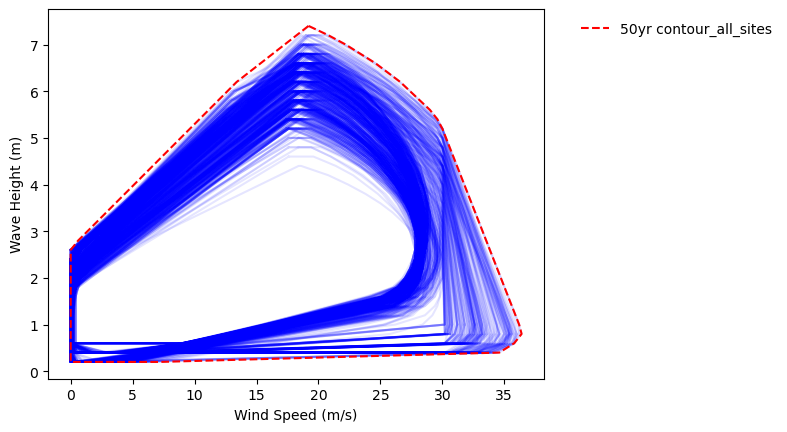

In [50]:
X_all=np.empty((0))
Y_all=np.empty((0))
for i in tqdm(Idx):
    ProbSurfaceVariables=Results[i]
    x=np.array(ProbSurfaceVariables)[:,0]
    y=np.array(ProbSurfaceVariables)[:,1]
    X_all=np.concatenate((X_all, x))
    Y_all=np.concatenate((Y_all, y))
    #get the outer boundary
    # Combine x and y points into a single array
    points = np.column_stack((x, y))

    # Compute the convex hull
    hull = ConvexHull(points)

    # Extract the outer boundary points
    outer_boundary_points = np.append(points[hull.vertices], [points[hull.vertices][0]], axis=0)

    plt.plot(outer_boundary_points[:, 0], outer_boundary_points[:, 1], 'b-', alpha=0.1)


#Overlap of all sites
points = np.column_stack((np.array(X_all), np.array(Y_all)))
# Compute the convex hull
hull = ConvexHull(points)

# Extract the outer boundary points
outer_boundary_points = np.append(points[hull.vertices], [points[hull.vertices][0]], axis=0)

df = pd.DataFrame({"WindSpeed":points[hull.vertices][:,0], "WaveHeight":points[hull.vertices][:,1]})
df.to_csv("./InputData/Wave/50yr_Wind_Wave.csv", index=False)

plt.plot(outer_boundary_points[:, 0], outer_boundary_points[:, 1], 'r--', alpha=1, label="50yr contour_all_sites")

plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Wave Height (m)")
# plt.ylabel("Wave Period (s)")
#legend on the left, outside the plot
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc='upper left')


In [ ]:
X_all=np.empty((0))
Y_all=np.empty((0))
Z_all=np.empty((0))
for i in tqdm(Idx):
    ProbSurfaceVariables=Results[i]
    x=np.array(ProbSurfaceVariables)[:,0]#WS
    y=np.array(ProbSurfaceVariables)[:,1]#Wave height
    z=np.array(ProbSurfaceVariables)[:,2]#Wave period
    
    X_all=np.concatenate((X_all, x))
    Y_all=np.concatenate((Y_all, y))
    Z_all=np.concatenate((Z_all, z))

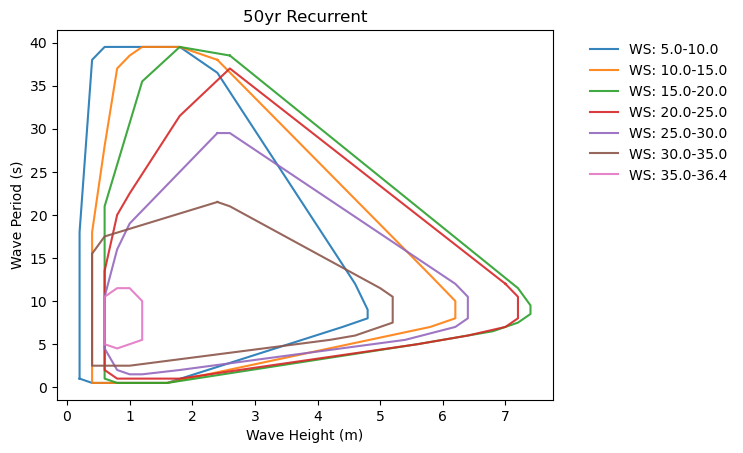

In [70]:
WS_Range=[5, 10, 15, 20,25,30,35,np.max(X_all)]
Dict={}
excel_writer = pd.ExcelWriter("./InputData/Wave/50yr_Wind_WaveHeightPeriod.xlsx", engine='xlsxwriter')

for Ws in range(len(WS_Range)-1):
    Idx_tmp=np.where((X_all>=WS_Range[Ws])*(X_all<WS_Range[Ws+1]))[0]
    points = np.column_stack((Y_all[Idx_tmp], Z_all[Idx_tmp]))
    hull = ConvexHull(points)
    outer_boundary_points = np.append(points[hull.vertices], [points[hull.vertices][0]], axis=0)
    plt.plot(outer_boundary_points[:, 0], outer_boundary_points[:, 1], alpha=0.9,label="WS: "+"{:.1f}".format(WS_Range[Ws])+"-"+"{:.1f}".format(WS_Range[Ws+1]))
    
    df=pd.DataFrame({"Wave Height":outer_boundary_points[:, 0], "Wave Period":outer_boundary_points[:, 1]})
    df.to_excel(excel_writer, sheet_name="WS "+"{:.1f}".format(WS_Range[Ws])+"-"+"{:.1f}".format(WS_Range[Ws+1]), index=False)
          
excel_writer.close()


plt.title("50yr Recurrent")
plt.xlabel("Wave Height (m)")
plt.ylabel("Wave Period (s)")
#legend on the left, outside the plot
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc='upper left')

## 100yrs

In [9]:
Data=np.load("./InputData/Wave/EVA_100y_ProbSurfaceVariables.npz", allow_pickle=True)["Data"].item()
Results=Data["Results"]


100%|██████████| 732/732 [00:32<00:00, 22.43it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


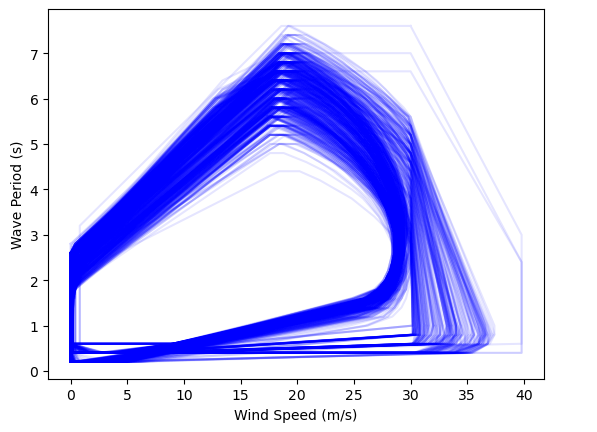

In [12]:
for i in tqdm(range(len(Results))):
    ProbSurfaceVariables=Results[i]
    x=np.array(ProbSurfaceVariables)[:,0]
    y=np.array(ProbSurfaceVariables)[:,1]
    #get the outer boundary
    # Combine x and y points into a single array
    points = np.column_stack((x, y))

    # Compute the convex hull
    hull = ConvexHull(points)

    # Extract the outer boundary points
    outer_boundary_points = np.append(points[hull.vertices], [points[hull.vertices][0]], axis=0)

    plt.plot(outer_boundary_points[:, 0], outer_boundary_points[:, 1], 'b-', alpha=0.1)


#Overlap of all sites

plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Wave Height (m)")
plt.ylabel("Wave Period (s)")
#legend on the left, outside the plot
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc='upper left')


100%|██████████| 732/732 [00:26<00:00, 27.31it/s]


Text(0.5, 1.0, 'Max 100y Wind Speed')

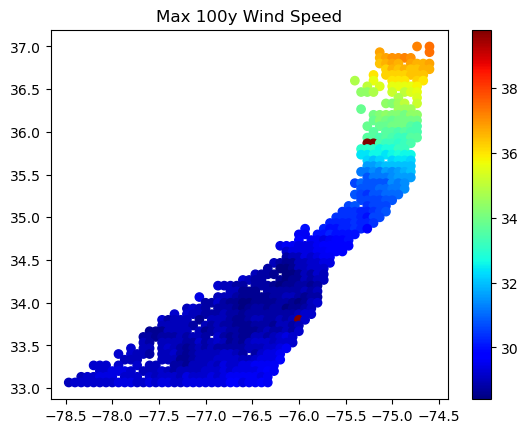

In [14]:
#Wave Data
Npz_Wave=np.load(PathWaveDate, allow_pickle=True)
LatLong=Npz_Wave["LatLong"]

Max100yWind=[]
Max100yWaveHeight=[]
for i in tqdm(range(len(Results))):
    ProbSurfaceVariables=Results[i]
    x=np.array(ProbSurfaceVariables)[:,0]
    y=np.array(ProbSurfaceVariables)[:,1]
    Max100yWind.append(np.max(x))
    Max100yWaveHeight.append(np.max(y))

plt.scatter(LatLong[:,1], LatLong[:,0], c=Max100yWind, cmap='jet')
plt.colorbar()
plt.title("Max 100y Wind Speed")

In [15]:
#The indexed above 37 m/s of wind speed does not look consitent, lets exclude them
Max100yWind=np.array(Max100yWind)
Max100yWaveHeight=np.array(Max100yWaveHeight)
Idx=np.where(Max100yWind<39)[0]

Max100yWind=[]
Max100yWaveHeight=[]
for i in tqdm(Idx):
    ProbSurfaceVariables=Results[i]
    x=np.array(ProbSurfaceVariables)[:,0]
    y=np.array(ProbSurfaceVariables)[:,1]
    Max100yWind.append(np.max(x))
    Max100yWaveHeight.append(np.max(y))


100%|██████████| 729/729 [00:26<00:00, 27.17it/s]


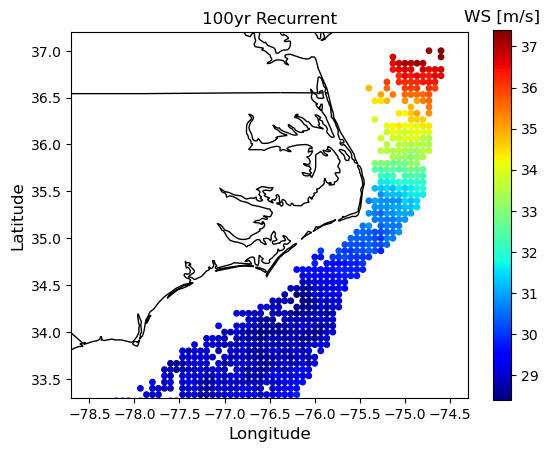

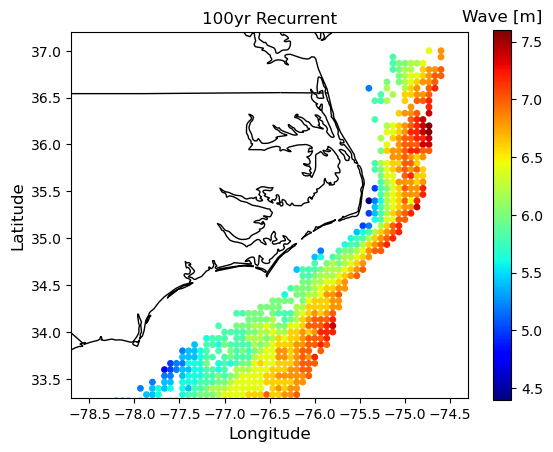

In [33]:
PlotGeneralGeoData(LatLong[Idx,:], Max100yWind, GeoDataPath, ColorBarTitle="WS [m/s]", Title="100yr Recurrent", SavePath=None, s=15, LatMaxMin=(33.3, 37.2), LongMaxMin=(-78.7, -74.3))
PlotGeneralGeoData(LatLong[Idx,:], Max100yWaveHeight, GeoDataPath, ColorBarTitle="Wave [m]", Title="100yr Recurrent", SavePath=None, s=15, LatMaxMin=(33.3, 37.2), LongMaxMin=(-78.7, -74.3))

100%|██████████| 729/729 [01:37<00:00,  7.50it/s]


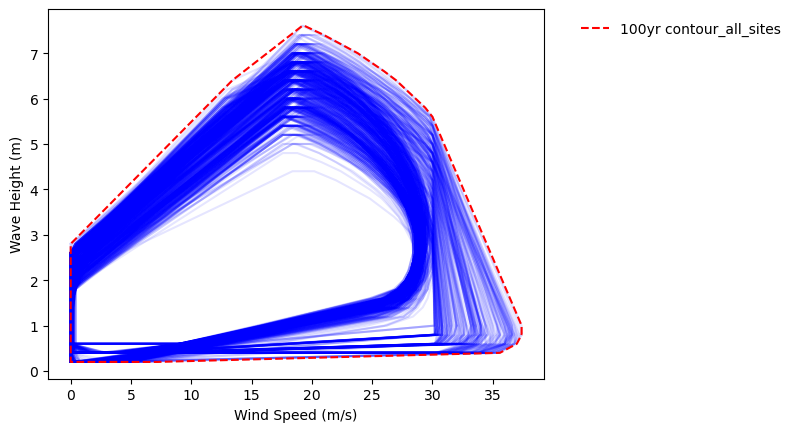

In [16]:
X_all=np.empty((0))
Y_all=np.empty((0))
for i in tqdm(Idx):
    ProbSurfaceVariables=Results[i]
    x=np.array(ProbSurfaceVariables)[:,0]
    y=np.array(ProbSurfaceVariables)[:,1]
    X_all=np.concatenate((X_all, x))
    Y_all=np.concatenate((Y_all, y))
    #get the outer boundary
    # Combine x and y points into a single array
    points = np.column_stack((x, y))

    # Compute the convex hull
    hull = ConvexHull(points)

    # Extract the outer boundary points
    outer_boundary_points = np.append(points[hull.vertices], [points[hull.vertices][0]], axis=0)

    plt.plot(outer_boundary_points[:, 0], outer_boundary_points[:, 1], 'b-', alpha=0.1)


#Overlap of all sites
points = np.column_stack((np.array(X_all), np.array(Y_all)))
# Compute the convex hull
hull = ConvexHull(points)

# Extract the outer boundary points
outer_boundary_points = np.append(points[hull.vertices], [points[hull.vertices][0]], axis=0)

df = pd.DataFrame({"WindSpeed":points[hull.vertices][:,0], "WaveHeight":points[hull.vertices][:,1]})
df.to_csv("./InputData/Wave/100yr_Wind_Wave.csv", index=False)

plt.plot(outer_boundary_points[:, 0], outer_boundary_points[:, 1], 'r--', alpha=1, label="100yr contour_all_sites")

plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Wave Height (m)")
# plt.ylabel("Wave Period (s)")
#legend on the left, outside the plot
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc='upper left')


In [17]:
X_all=np.empty((0))
Y_all=np.empty((0))
Z_all=np.empty((0))
for i in tqdm(Idx):
    ProbSurfaceVariables=Results[i]
    x=np.array(ProbSurfaceVariables)[:,0]#WS
    y=np.array(ProbSurfaceVariables)[:,1]#Wave height
    z=np.array(ProbSurfaceVariables)[:,2]#Wave period
    
    X_all=np.concatenate((X_all, x))
    Y_all=np.concatenate((Y_all, y))
    Z_all=np.concatenate((Z_all, z))

100%|██████████| 729/729 [02:24<00:00,  5.06it/s]


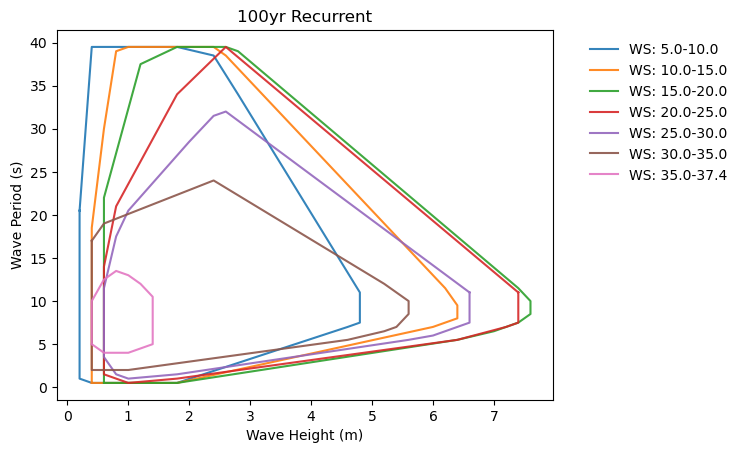

In [18]:
WS_Range=[5, 10, 15, 20,25,30,35,np.max(X_all)]
Dict={}
excel_writer = pd.ExcelWriter("./InputData/Wave/100yr_Wind_WaveHeightPeriod.xlsx", engine='xlsxwriter')

for Ws in range(len(WS_Range)-1):
    Idx_tmp=np.where((X_all>=WS_Range[Ws])*(X_all<WS_Range[Ws+1]))[0]
    points = np.column_stack((Y_all[Idx_tmp], Z_all[Idx_tmp]))
    hull = ConvexHull(points)
    outer_boundary_points = np.append(points[hull.vertices], [points[hull.vertices][0]], axis=0)
    plt.plot(outer_boundary_points[:, 0], outer_boundary_points[:, 1], alpha=0.9,label="WS: "+"{:.1f}".format(WS_Range[Ws])+"-"+"{:.1f}".format(WS_Range[Ws+1]))
    
    df=pd.DataFrame({"Wave Height":outer_boundary_points[:, 0], "Wave Period":outer_boundary_points[:, 1]})
    df.to_excel(excel_writer, sheet_name="WS "+"{:.1f}".format(WS_Range[Ws])+"-"+"{:.1f}".format(WS_Range[Ws+1]), index=False)
          
excel_writer.close()


plt.title("100yr Recurrent")
plt.xlabel("Wave Height (m)")
plt.ylabel("Wave Period (s)")
#legend on the left, outside the plot
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc='upper left')